In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
from graspy.utils import *
from graspy.embed import AdjacencySpectralEmbed
from graspy.plot import heatmap, pairplot
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re

FONTSIZE=20

In [2]:
df = pd.read_excel('SI 3 Synapse lists.xlsx')

In [3]:
new_labels = ['num_contin', 'em_series', 'pre', 'all_post', 'type', 'sections',
 'num_post', 'post1', 'post2', 'post3', 'post4']
df.columns = new_labels

Text(0.5,1,'Chemical synapse partner number distribution')

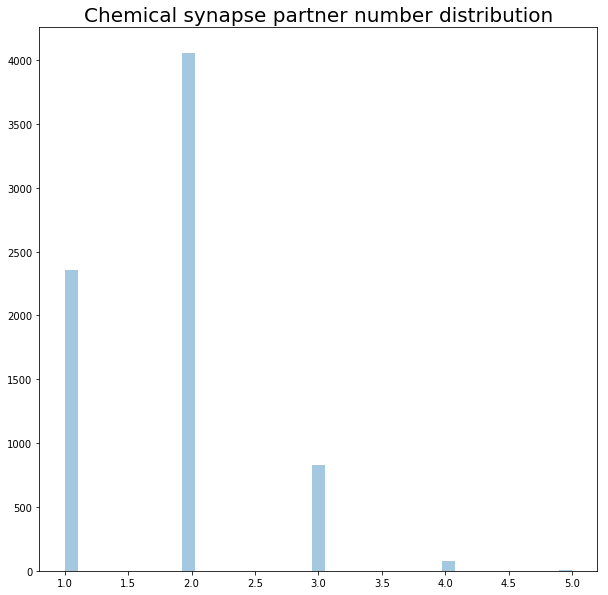

In [4]:
chem = df.loc[df['type'] == 'chemical']
elec = df.loc[df['type'] == 'electrical']
ax = plt.subplots(1,1, figsize=(10,10))[1]
sns.distplot(chem['num_post'].values, kde=False, ax=ax, )
ax.set_title('Chemical synapse partner number distribution', fontsize=FONTSIZE)

In [7]:
def df_to_adjacency(df, weight=1):
    rows = []
    for i, row in  df.iterrows():
        post_names = row.all_post.split(',')
        for a in post_names:
            # pre | post | weight
            rows.append([row.pre, a, weight])

    df_split = pd.DataFrame(rows, columns=['source', 'target', 'weight'])
    g = nx.MultiDiGraph()
    g = nx.from_pandas_edgelist(df_split, create_using=g)
    A_sparse = nx.adjacency_matrix(g) 
    A = np.asarray(A_sparse.todense())
    return A


In [8]:
chem_A = df_to_adjacency(chem)
elec_A = df_to_adjacency(elec)
# heatmap(chem_A, figsize=(20,20))
# heatmap(chem_A, transform='log', figsize=(20,20))
# heatmap(elec_A)
gridplot([chem_A], ['chem',], height=50)
gridplot([chem_A[:100,:100]], ['chem'], height=20)
gridplot([chem_A,], ['chem'], height=20,)
# heatmap(chem_A, figsize=(20,20))

NameError: name 'gridplot' is not defined

In [11]:
# loops exist!
print(sum(np.diag(chem_A)))

63


In [14]:
def _check_common_inputs(figsize=None,
                         height=None,
                         title=None,
                         context=None,
                         font_scale=None,
                         legend_name=None):
    # Handle figsize
    if figsize is not None:
        if not isinstance(figsize, tuple):
            msg = 'figsize must be a tuple, not {}.'.format(type(figsize))
            raise TypeError(msg)

    # Handle heights
    if height is not None:
        if not isinstance(height, (int, float)):
            msg = 'height must be an integer or float, not {}.'.format(
                type(height))
            raise TypeError(msg)

    # Handle title
    if title is not None:
        if not isinstance(title, str):
            msg = 'title must be a string, not {}.'.format(type(title))
            raise TypeError(msg)

    # Handle context
    if context is not None:
        if not isinstance(context, str):
            msg = 'context must be a string, not {}.'.format(type(context))
            raise TypeError(msg)
        elif not context in ['paper', 'notebook', 'talk', 'poster']:
            msg = 'context must be one of (paper, notebook, talk, poster), \
                not {}.'.format(context)
            raise ValueError(msg)

    # Handle font_scale
    if font_scale is not None:
        if not isinstance(font_scale, (int, float)):
            msg = 'font_scale must be an integer or float, not {}.'.format(
                type(font_scale))
            raise TypeError(msg)

    # Handle legend name
    if legend_name is not None:
        if not isinstance(legend_name, str):
            msg = 'legend_name must be a string, not {}.'.format(
                type(legend_name))
            raise TypeError(msg)
            
def _transform(arr, method):
    if method is not None:
        if method == 'log':
            #arr = np.log(arr, where=(arr > 0))
            #hacky, but np.log(arr, where=arr>0) is really buggy
            arr = arr.copy()
            arr[arr > 0] = np.log(arr[arr > 0])
        elif method in ['zero-boost', 'simple-all', 'simple-nonzero']:
            arr = pass_to_ranks(arr, method=method)
        else:
            msg = 'Transform must be one of {log, zero-boost, simple-all, \
            simple-nonzero, not {}.'.format(method)
            raise ValueError(msg)

    return arr


In [15]:
def gridplot(X,
             labels,
             transform=None,
             height=10,
             title=None,
             context='talk',
             font_scale=1):
    """
    Plots multiple graphs as a grid, with intensity denoted by the size 
    of dots on the grid.

    Parameters
    ----------
    X : list of nx.Graph or np.ndarray object
        List of nx.Graph or numpy arrays to plot
    labels : list of str
        List of strings, which are labels for each element in X. 
        `len(X) == len(labels)`.
    transform : None, or string {log, zero-boost, simple-all, simple-nonzero}
        log :
            Plots the log of all nonzero numbers
        zero-boost :
            Pass to ranks method. preserves the edge weight for all 0s, but ranks 
            the other edges as if the ranks of all 0 edges has been assigned. 
        'simple-all': 
            Pass to ranks method. Assigns ranks to all non-zero edges, settling 
            ties using the average. Ranks are then scaled by 
                .. math:: \frac{2 rank(non-zero edges)}{n^2 + 1}
            where n is the number of nodes
        'simple-nonzero':
            Pass to ranks method. Same as 'simple-all' but ranks are scaled by
                .. math:: \frac{2 rank(non-zero edges)}{num_nonzero + 1}
    height : int, optional, default: 10
        Height of figure in inches.
    title : str, optional, default: None
        Title of plot.
    context :  None, or one of {paper, notebook, talk (default), poster}
        The name of a preconfigured set.
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    """
    _check_common_inputs(
        height=height, title=title, context=context, font_scale=font_scale)

    if isinstance(X, list):
        graphs = [import_graph(x) for x in X]
    else:
        msg = 'X must be a list, not {}.'.format(type(X))
        raise TypeError(msg)

    # Handle labels
    if not isinstance(labels, list):
        msg = 'labels must be a list, not {}.'.format(type(labels))
        raise TypeError(msg)
    elif len(labels) != len(graphs):
        msg = 'Expected {} elements in labels, but got {} instead.'.format(
            len(graphs), len(labels))
        raise ValueError(msg)

    graphs = [_transform(arr, transform) for arr in graphs]

    palette = sns.color_palette('Set1', desat=0.75, n_colors=len(labels))

    dfs = []
    for idx, graph in enumerate(graphs):
        rdx, cdx = np.where(graph > 0)
        weights = graph[(rdx, cdx)]
        df = pd.DataFrame(
            np.vstack([cdx, rdx[::-1], weights]).T,
            columns=['cdx', 'rdx', 'Weights'])
        df['Type'] = [labels[idx]] * len(cdx)
        dfs.append(df)
    
    df = pd.concat(dfs, axis=0)
    with sns.plotting_context(context, font_scale=font_scale):
        plot = sns.relplot(
            data=df,
            x='cdx',
            y='rdx',
            hue='Type',
            size='Weights',
            sizes=(10, 400),
            alpha=0.5,
            palette=palette,
            height=height,
            aspect=1)
        plot.ax.axis('off')
        if title is not None:
            plot.set(title=title)

    return plot


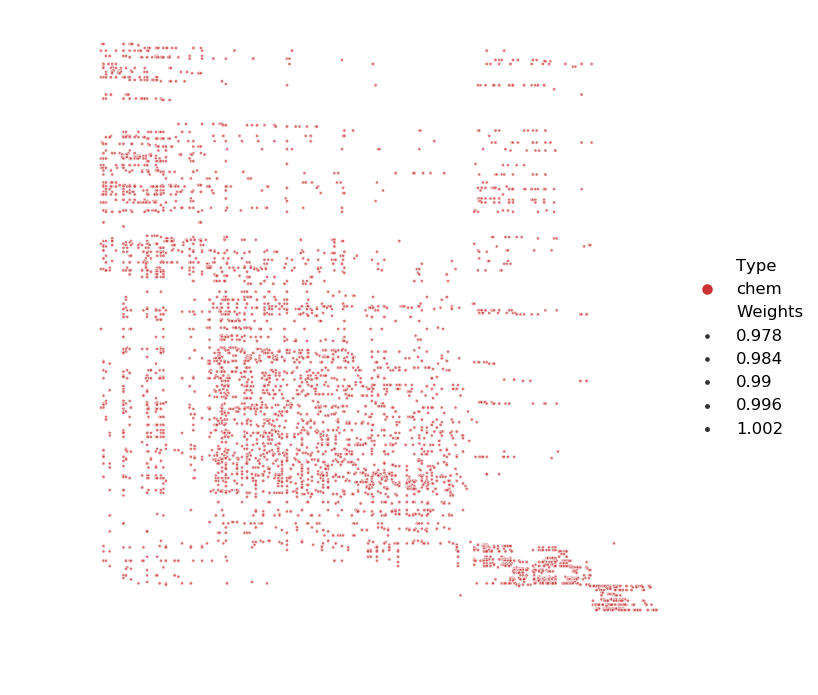

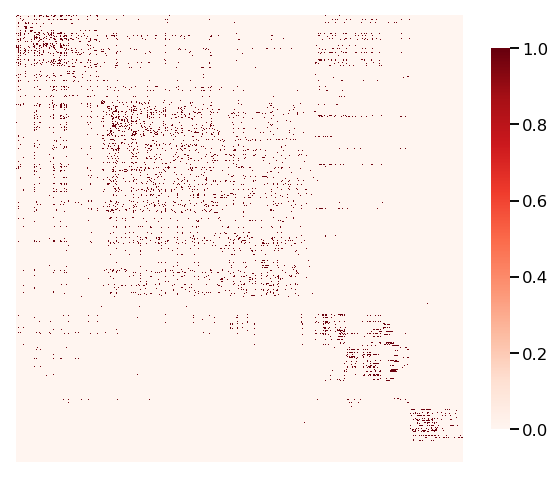

In [17]:
X = [pass_to_ranks(chem_A)]
labels = ['chem']
transform=None
height=10
title=None
context='talk'
font_scale=1
_check_common_inputs(
    height=height, title=title, context=context, font_scale=font_scale)

if isinstance(X, list):
    graphs = [import_graph(x) for x in X]
else:
    msg = 'X must be a list, not {}.'.format(type(X))
    raise TypeError(msg)

# Handle labels
if not isinstance(labels, list):
    msg = 'labels must be a list, not {}.'.format(type(labels))
    raise TypeError(msg)
elif len(labels) != len(graphs):
    msg = 'Expected {} elements in labels, but got {} instead.'.format(
        len(graphs), len(labels))
    raise ValueError(msg)

graphs = [_transform(arr, transform) for arr in graphs]

palette = sns.color_palette('Set1', desat=0.75, n_colors=len(labels))

dfs = []
for idx, graph in enumerate(graphs):
    rdx, cdx = np.where(graph > 0)
    weights = graph[(rdx, cdx)]
    df = pd.DataFrame(
        np.vstack([rdx[::-1], cdx, weights]).T,
        columns=['rdx', 'cdx', 'Weights'])
    df['Type'] = [labels[idx]] * len(cdx)
    dfs.append(df)

df = pd.concat(dfs, axis=0)

with sns.plotting_context(context, font_scale=font_scale):
    plot = sns.relplot(
        data=df,
        x='cdx',
        y='rdx',
        hue='Type',
        size='Weights',
        sizes=(10, 12),
        alpha=0.7,
        palette=palette,
        height=height)
    plot.ax.axis('off')
    if title is not None:
        plot.set(title=title)
heatmap(pass_to_ranks(chem_A))

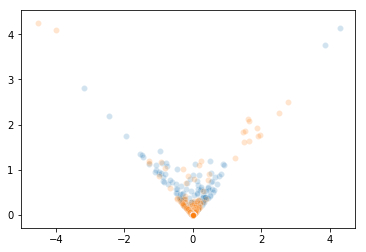

In [18]:
ase = AdjacencySpectralEmbed(k=100)
Xhat, Yhat = ase.fit_transform(chem_A)
dim1=98
dim2=99
sns.scatterplot(Xhat[:,dim1], Xhat[:,dim2], alpha = 0.2)
# plt.show()
sns.scatterplot(Yhat[:,dim1], Yhat[:,dim2], alpha = 0.2)
plt.show()

In [20]:
# alpha = 0.2
# plot_kws = {'alpha':0.2}
# sns.pairplot(pd.DataFrame(Xhat), plot_kws=plot_kws)
# sns.pairplot(pd.DataFrame(Yhat), plot_kws=plot_kws)

In [19]:
np.linalg.norm(Xhat @ Yhat.T - chem_A)

78.0210737120995

In [20]:
chem = chem.sort_values('pre')

In [21]:
chem_1 = chem.loc[chem['num_post'] == 1]
chem_2 = chem.loc[chem['num_post'] == 2]
chem_3 = chem.loc[chem['num_post'] == 3]
chem_4 = chem.loc[chem['num_post'] == 4]
chem.loc[chem['num_post'] == 5]

,num_contin,em_series,pre,all_post,type,sections,num_post,post1,post2,post3,post4
3451,3974,N2U,ADAR,"RIPR,PVR.,AVBL,RIVR,AVJL",chemical,5,5,RIPR,PVR,AVBL,NaN
4971,9892,N2U,AVDL,"AVAL,SABD,AVEL,DA01,VA01",chemical,2,5,AVAL,SABD,AVEL,NaN
1174,1047,N2U,RIAL,"SMDDL,obj25487,obj25486,obj25485,obj25484",chemical,4,5,SMDDL,obj25487,obj25486,NaN
3722,4314,N2U,RIVR,"GLRVL,GLRVR,vBWMR7,vBWMR6,RIVL",chemical,8,5,GLRVL,GLRVR,vBWMR7,NaN
3222,3664,N2U,RMDVR,"vBWML1,URAVL.,vBWML5,RMDDL,vBWML4",chemical,6,5,vBWML1,URAVL,vBWML5,NaN
1187,1063,N2U,SMDVR,"vBWML6,vBWML2,SMDDL,vBWML3,RMED",chemical,9,5,vBWML6,vBWML2,SMDDL,NaN


In [22]:
chem_1_A = df_to_adjacency(chem_1)
chem_2_A = df_to_adjacency(chem_2)
chem_3_A = df_to_adjacency(chem_3)
chem_4_A = df_to_adjacency(chem_4)

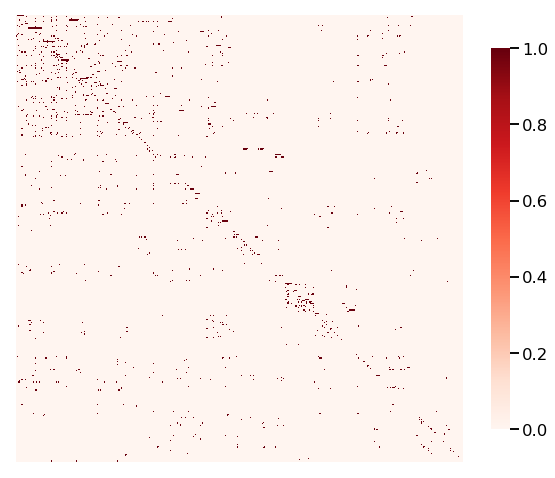

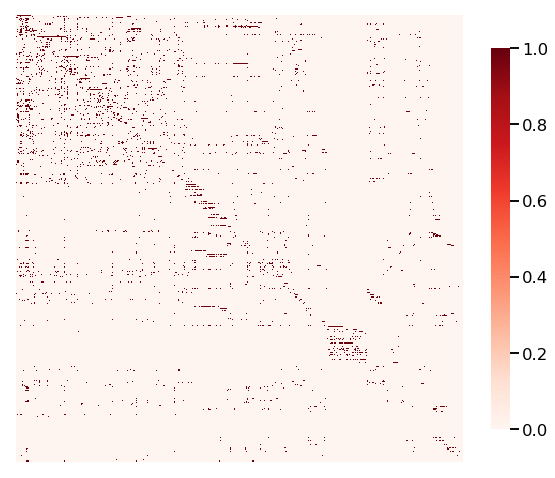

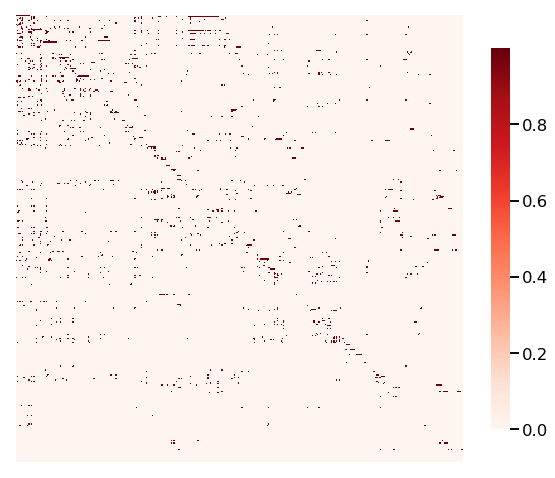

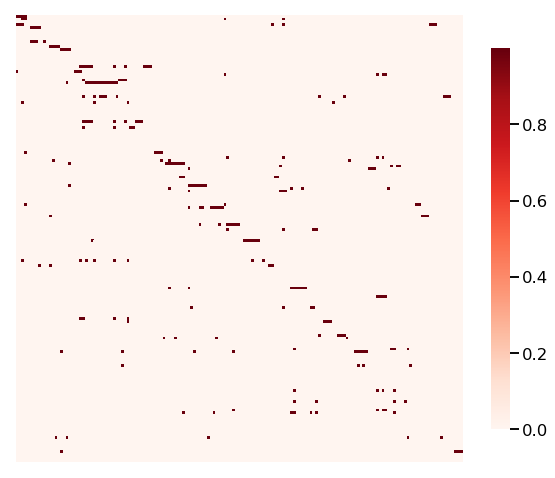

In [23]:
heatmap(pass_to_ranks(chem_1_A))
heatmap(pass_to_ranks(chem_2_A))
heatmap(pass_to_ranks(chem_3_A))
heatmap(pass_to_ranks(chem_4_A))

In [24]:
# rows = []
# for i, row in  df.iterrows():
#     post_names = row.all_post.split(',')
#     for a in post_names:
#         # pre | post | weight
#         rows.append([row.pre, a, weight])

# df_split = pd.DataFrame(rows, columns=['source', 'target', 'weight'])
# g = nx.MultiDiGraph()
# g = nx.from_pandas_edgelist(df_split, create_using=g)
# A_sparse = nx.adjacency_matrix(g) 
# A = np.asarray(A_sparse.todense())
# return A

AttributeError: 'Series' object has no attribute 'all_post'

In [29]:
adic_graphs = [nx.MultiDiGraph() for n in range(5)]

In [28]:
for i, row in chem.iterrows():
    pre = row.pre
    post_names = row.all_post.split(',')
    post_names = re.split('[, .]', row.all_post)
    for g in adic_graphs:
        g.add_node(pre)
        [g.add_node(post) for post in post_names]
    [adic_graphs[row.num_post - 1].add_edge(pre, post, weight=1) for post in post_names]



In [30]:
def get_adj(g):
    return np.asarray(nx.adjacency_matrix(g).todense()) 

ValueError: zero-size array to reduction operation minimum which has no identity

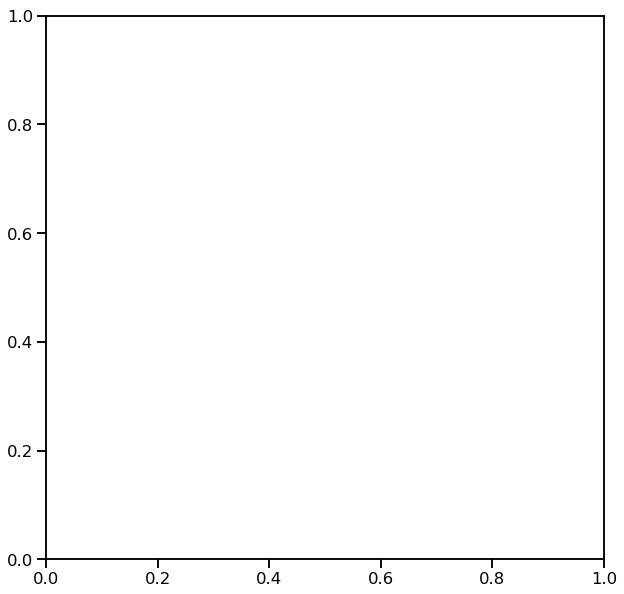

In [31]:
adic_As = [nx.to_numpy_array(g) for g in adic_graphs]
[heatmap(A) for A in adic_As]

In [34]:
adic_graphs[0]

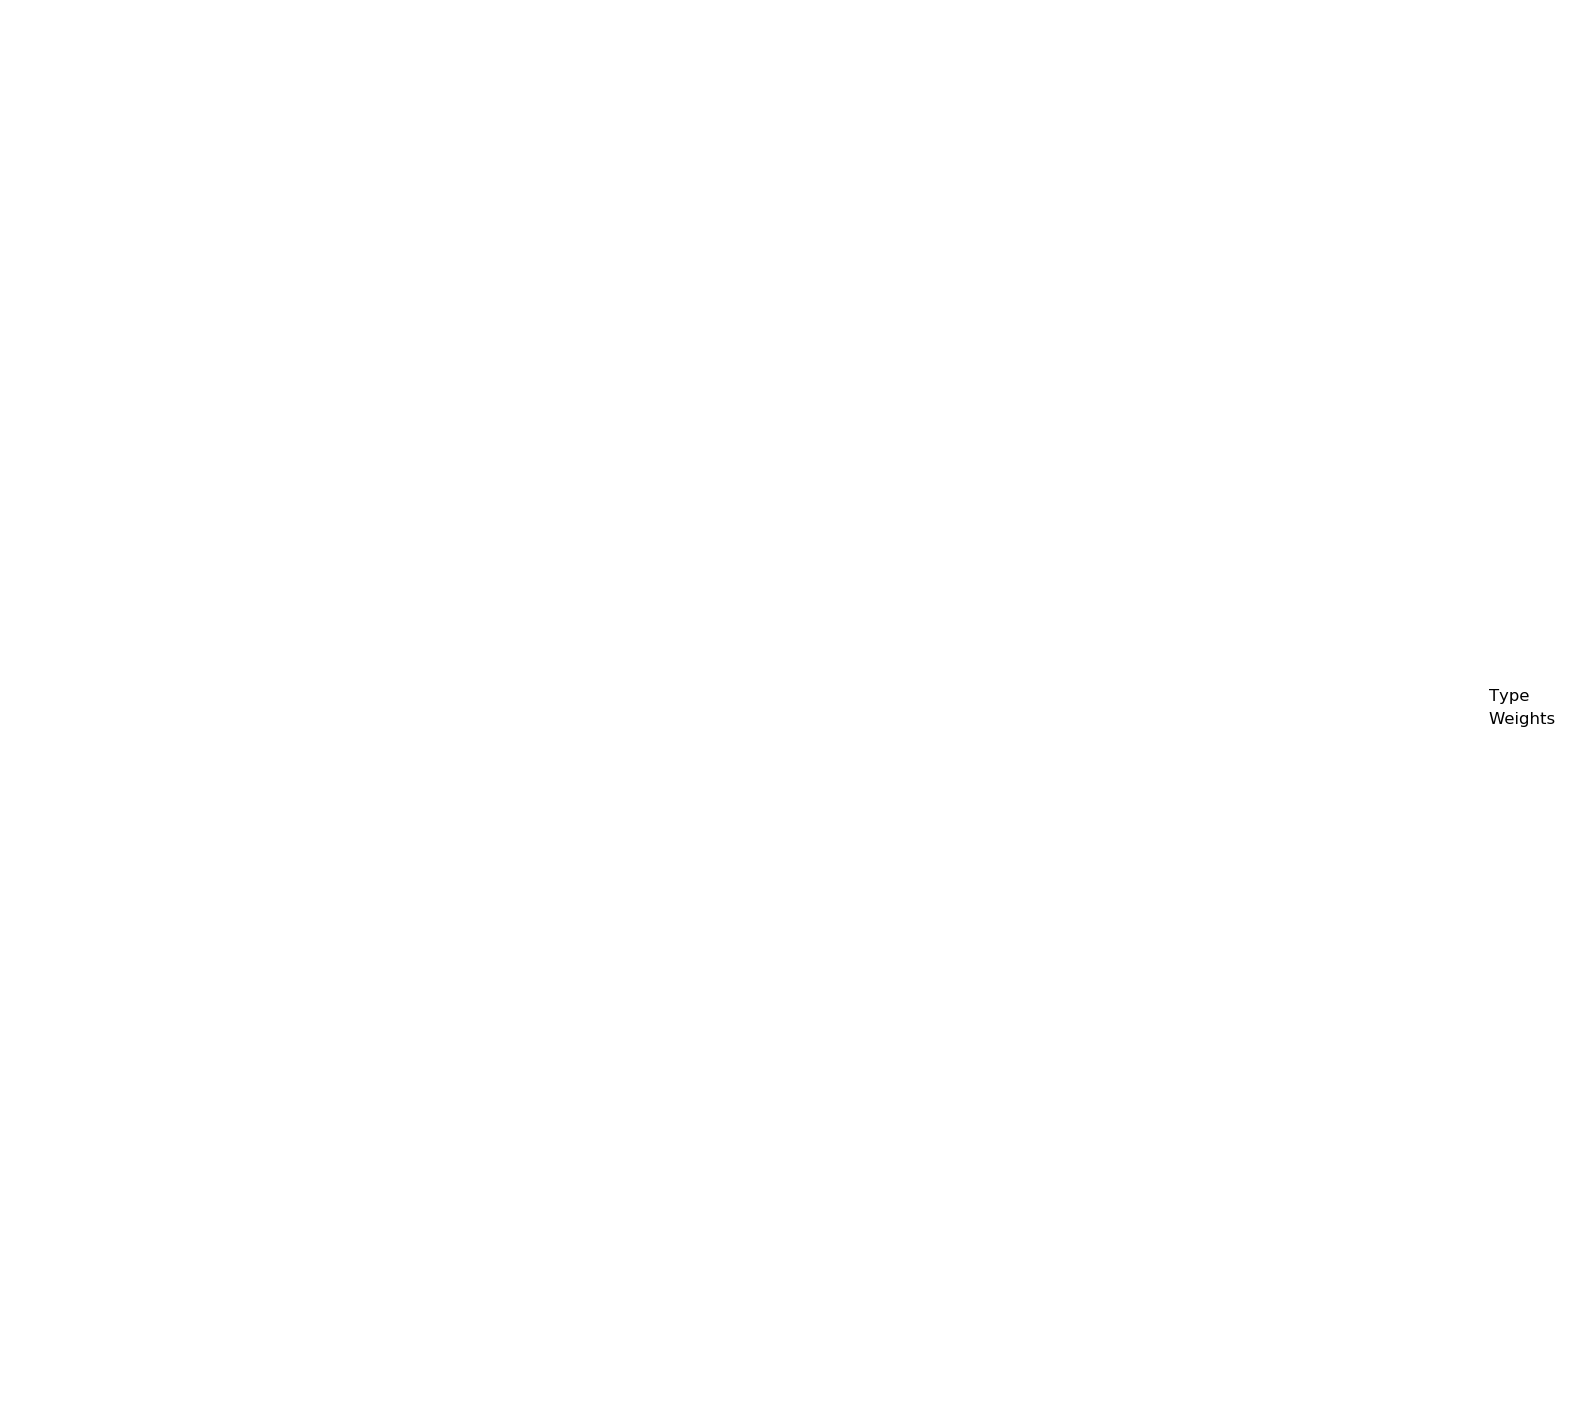

In [32]:
gridplot(adic_As, ['2', '3', '4', '5', '6'], height=20)

In [33]:
np.max(chem.num_post.values)

5

In [172]:
chem

,num_contin,em_series,pre,all_post,type,sections,num_post,post1,post2,post3,post4
4766,6001,N2U,ADAL,SMDVR,chemical,1,1,SMDVR,NaN,NaN,NaN
4569,5814,N2U,ADAL,"AIBL,AIAL",chemical,2,2,AIBL,AIAL,NaN,NaN
3830,10264,N2U,ADAL,"AVAL,AVJR,AVBL",chemical,1,3,AVAL,AVJR,AVBL,NaN
4078,4755,N2U,ADAL,RICL,chemical,1,1,RICL,NaN,NaN,NaN
4166,10272,N2U,ADAL,AVDR,chemical,1,1,AVDR,NaN,NaN,NaN
4021,4693,N2U,ADAL,ADLL,chemical,1,1,ADLL,NaN,NaN,NaN
3653,10261,N2U,ADAL,"AVJR,AVBL",chemical,1,2,AVJR,AVBL,NaN,NaN
4620,5859,N2U,ADAL,"ADAL,RIML,AVBR",chemical,6,3,ADAL,RIML,AVBR,NaN
4022,4694,N2U,ADAL,ADLL,chemical,1,1,ADLL,NaN,NaN,NaN
4026,4698,N2U,ADAL,AVBR,chemical,2,1,AVBR,NaN,NaN,NaN


In [34]:
keys = np.unique(chem.pre.values)
keys = adic_graphs[0].nodes
inds = range(len(keys))
ind_map = dict(zip(keys,inds))
ind_map

{'ADAL': 0,
 'SMDVR': 1,
 'AIBL': 2,
 'AIAL': 3,
 'AVAL': 4,
 'AVJR': 5,
 'AVBL': 6,
 'RICL': 7,
 'AVDR': 8,
 'ADLL': 9,
 'RIML': 10,
 'AVBR': 11,
 'RIPL': 12,
 'AVEL': 13,
 'URAVL': 14,
 '': 15,
 'AVDL': 16,
 'PVPL': 17,
 'AVAR': 18,
 'URXL': 19,
 'RICR': 20,
 'AIBR': 21,
 'ADAR': 22,
 'RIMR': 23,
 'ASHR': 24,
 'AVJL': 25,
 'URYDR': 26,
 'RIPR': 27,
 'RIFR': 28,
 'PVR': 29,
 'SMDVL': 30,
 'URXR': 31,
 'RIVR': 32,
 'ADEL': 33,
 'RIH': 34,
 'OLLL': 35,
 'RMDL': 36,
 'RMHR': 37,
 'dBWML5': 38,
 'IL1L': 39,
 'dBWML3': 40,
 'RMER': 41,
 'IL2L': 42,
 'vBWML1': 43,
 'CEPVL': 44,
 'CEPDL': 45,
 'ALML': 46,
 'AVL': 47,
 'RIFL': 48,
 'BDUL': 49,
 'URBL': 50,
 'RIGL': 51,
 'ADER': 52,
 'RIGR': 53,
 'FLPL': 54,
 'hyp': 55,
 'SMBDR': 56,
 'SAADR': 57,
 'RMGL': 58,
 'AVHL': 59,
 'SIADR': 60,
 'SIBDR': 61,
 'RIAL': 62,
 'RIVL': 63,
 'SMBVL': 64,
 'VB01': 65,
 'RMHL': 66,
 'RIAR': 67,
 'AVER': 68,
 'ASIR': 69,
 'FLPR': 70,
 'CEPDR': 71,
 'CEPVR': 72,
 'CEPshDR': 73,
 'dBWMR4': 74,
 'RMDR': 75,
 'OLLR

In [185]:
prod_monoadics = {}
num_polyads = {}
for i, row in chem_2.iterrows():
    pre = row.pre
    post1 = row.post1
    post2 = row.post2
    
    A_out = adic_As[0][ind_map[pre],:].sum()
    pA_B = adic_As[0][ind_map[pre], ind_map[post1]] / A_out
    pA_C = adic_As[0][ind_map[pre], ind_map[post2]] / A_out
    di_A_out = adic_As[1][ind_map[pre], :].sum()
    #monokey = 'A'
    key = pre + '->' + post1 + '+' + post2
    if key not in prod_monoadics:
        prod_monoadics[key] = pA_B * pA_C
    if key not in num_polyads:
        num_polyads[key] = 0
    num_polyads[key] += 1
    

In [187]:
prod_monoadics

{'ADAL->AIBL+AIAL': 0.0,
 'ADAL->AVJR+AVBL': 0.0,
 'ADAL->AVBR+RIPL': 0.0,
 'ADAL->AVJR+AVEL': 0.0,
 'ADAL->URAVL+RIPL': 0.0,
 'ADAL->AVJR+AVDL': 0.0,
 'ADAL->AVBR+AVAR': 0.0,
 'ADAL->AVDR+AVJR': 0.008264462809917356,
 'ADAL->AIBR+RIML': 0.0,
 'ADAR->AVBR+RIMR': 0.0,
 'ADAR->AVBR+AVDL': 0.0,
 'ADAR->AVBR+AVJL': 0.0,
 'ADAR->AVAR+AVBR': 0.0,
 'ADAR->RIMR+AIBR': 0.0,
 'ADAR->AVJL+AVDR': 0.0,
 'ADAR->RIMR+AVBL': 0.0,
 'ADAR->RIPR+PVR': 0.0,
 'ADAR->URXR+AVAR': 0.0,
 'ADAR->AVJL+AVAR': 0.0,
 'ADAR->AVAR+AVJL': 0.0,
 'ADAR->RIPR+AVBR': 0.0,
 'ADEL->RIVR+RIH': 0.0,
 'ADEL->OLLL+RMDL': 0.0036730945821854917,
 'ADEL->RMHR+dBWML5': 0.0,
 'ADEL->OLLL+IL1L': 0.0,
 'ADEL->dBWML3+RMER': 0.0,
 'ADEL->IL2L+RMER': 0.0,
 'ADEL->vBWML1+CEPVL': 0.0,
 'ADEL->vBWML1+RMER': 0.0,
 'ADEL->CEPDL+ALML': 0.0,
 'ADEL->RIFL+BDUL': 0.0,
 'ADEL->RMHR+RMHR': 0.0,
 'ADEL->RIGL+AVAR': 0.007346189164370983,
 'ADEL->ADER+RIGR': 0.0,
 'ADEL->SMBDR+SAADR': 0.0,
 'ADEL->OLLL+ADEL': 0.0036730945821854917,
 'ADEL->IL2L+RMDL':

In [68]:
def df_to_adjacency_undirected(df, weight=1):
    rows = []
    for i, row in  df.iterrows():
        post_names = re.split('[, .]', row.all_post)
        for a in post_names:
            # pre | post | weight
            rows.append([row.pre, a, weight])
    
    df_split = pd.DataFrame(rows, columns=['source', 'target', 'weight'])
    g = nx.MultiGraph()
    g = nx.from_pandas_edgelist(df_split, create_using=g)
    return nx.to_numpy_array(g)


In [69]:
chem_A_undirected = df_to_adjacency_undirected(chem)

In [70]:
chem_A_undirected.shape

(450, 450)

In [71]:
adic_undirected_graphs = [nx.MultiDiGraph() for n in range(5)]
for i, row in chem.iterrows():
    pre = row.pre
    post_names = re.split('[, .]', row.all_post)
    for g in adic_graphs:
        g.add_node(pre)
        [g.add_node(post) for post in post_names]
    [adic_undirected_graphs[row.num_post - 1].add_edge(pre, post, weight=1) for post in post_names]
adic_undirected_As = [nx.to_numpy_array(g) for g in adic_graphs]

In [72]:
num_possible = np.sum(chem_A_undirected, axis=1)
num_present = []
[num_present.append(np.sum(A, axis=1)) for ind, A in enumerate(adic_undirected_As)]

[None, None, None, None, None]

In [102]:
proportions = []
for adic_num_present in num_present:
#     print(adic_num_possible.shape)
#     print(num_pr.shape)
    proportions.append(np.divide(adic_num_present, num_possible))

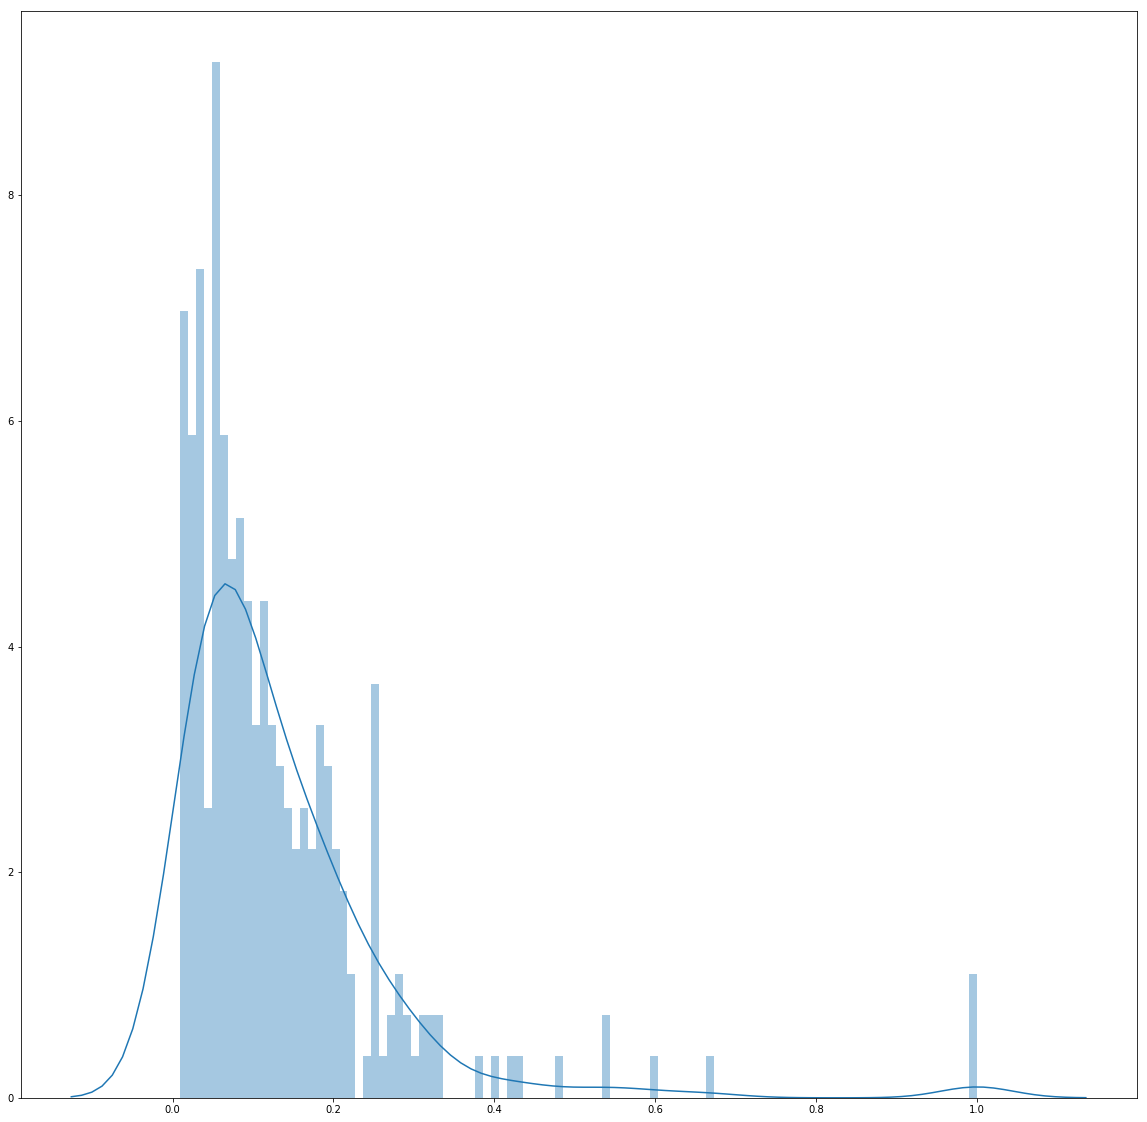

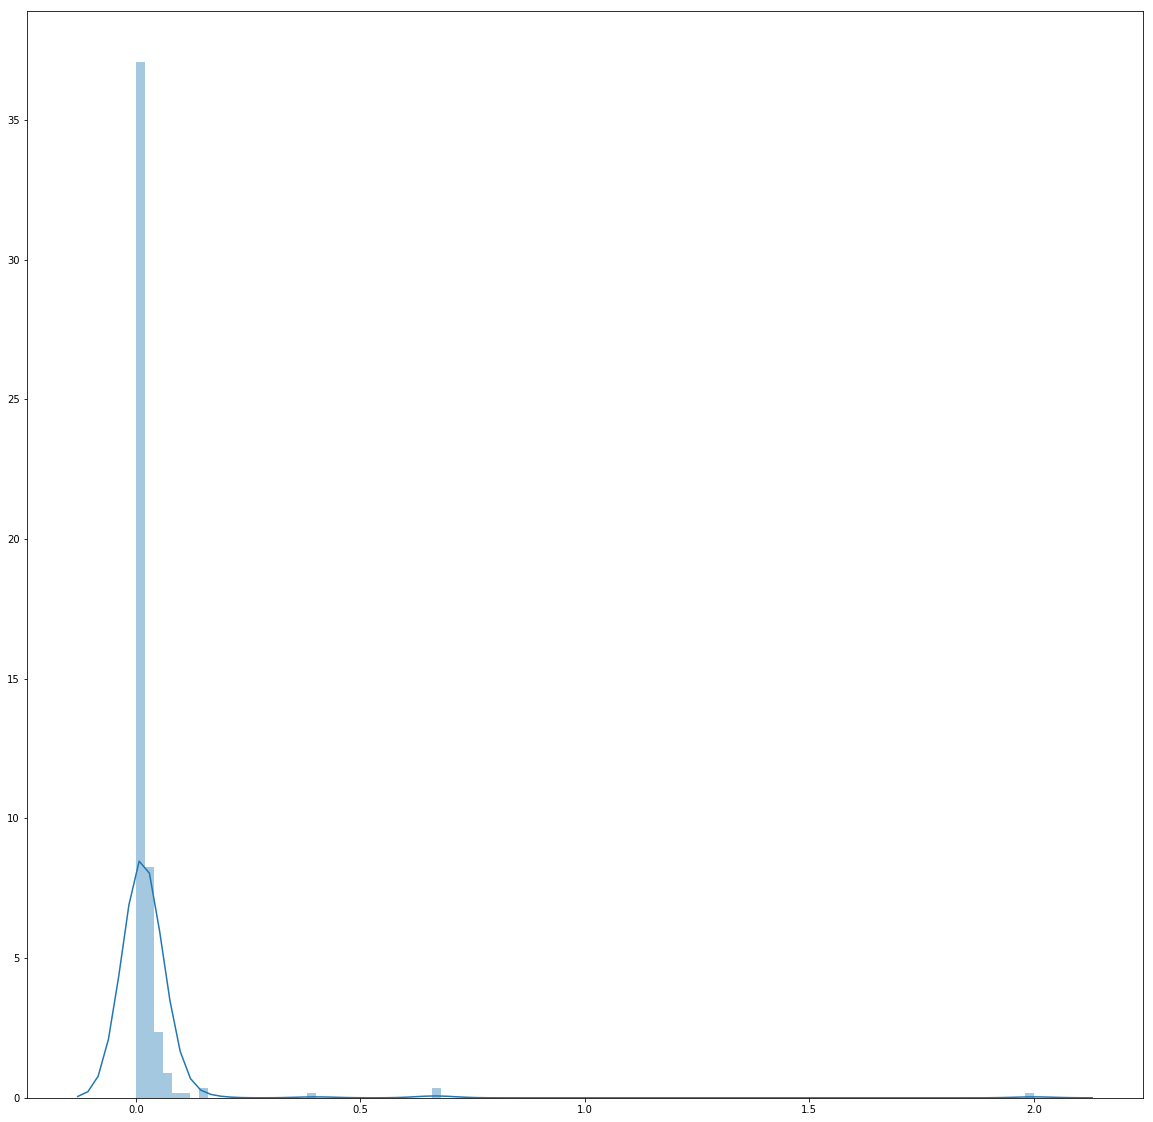

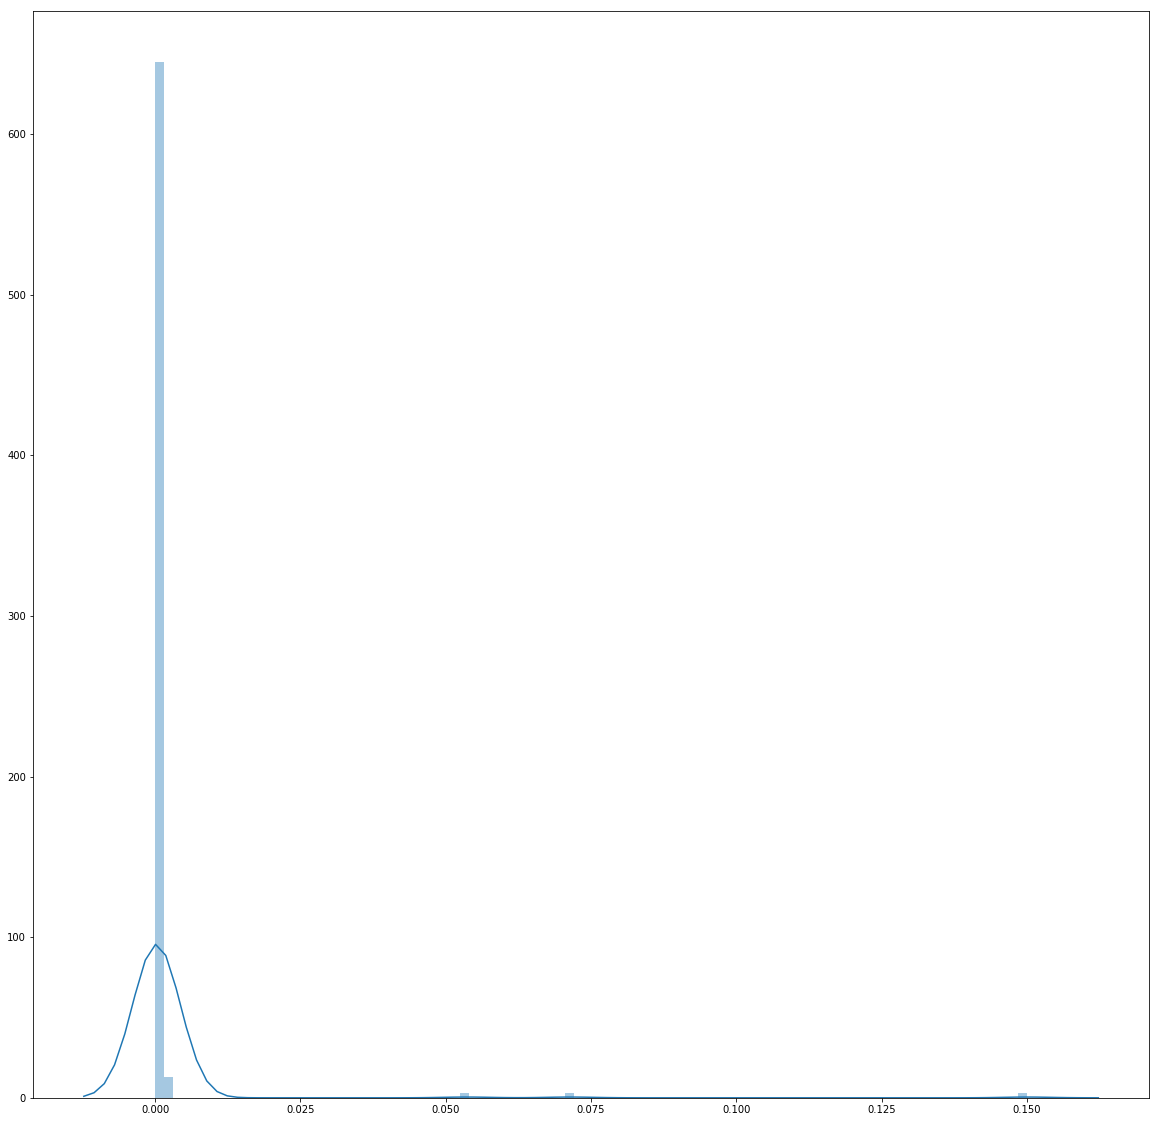

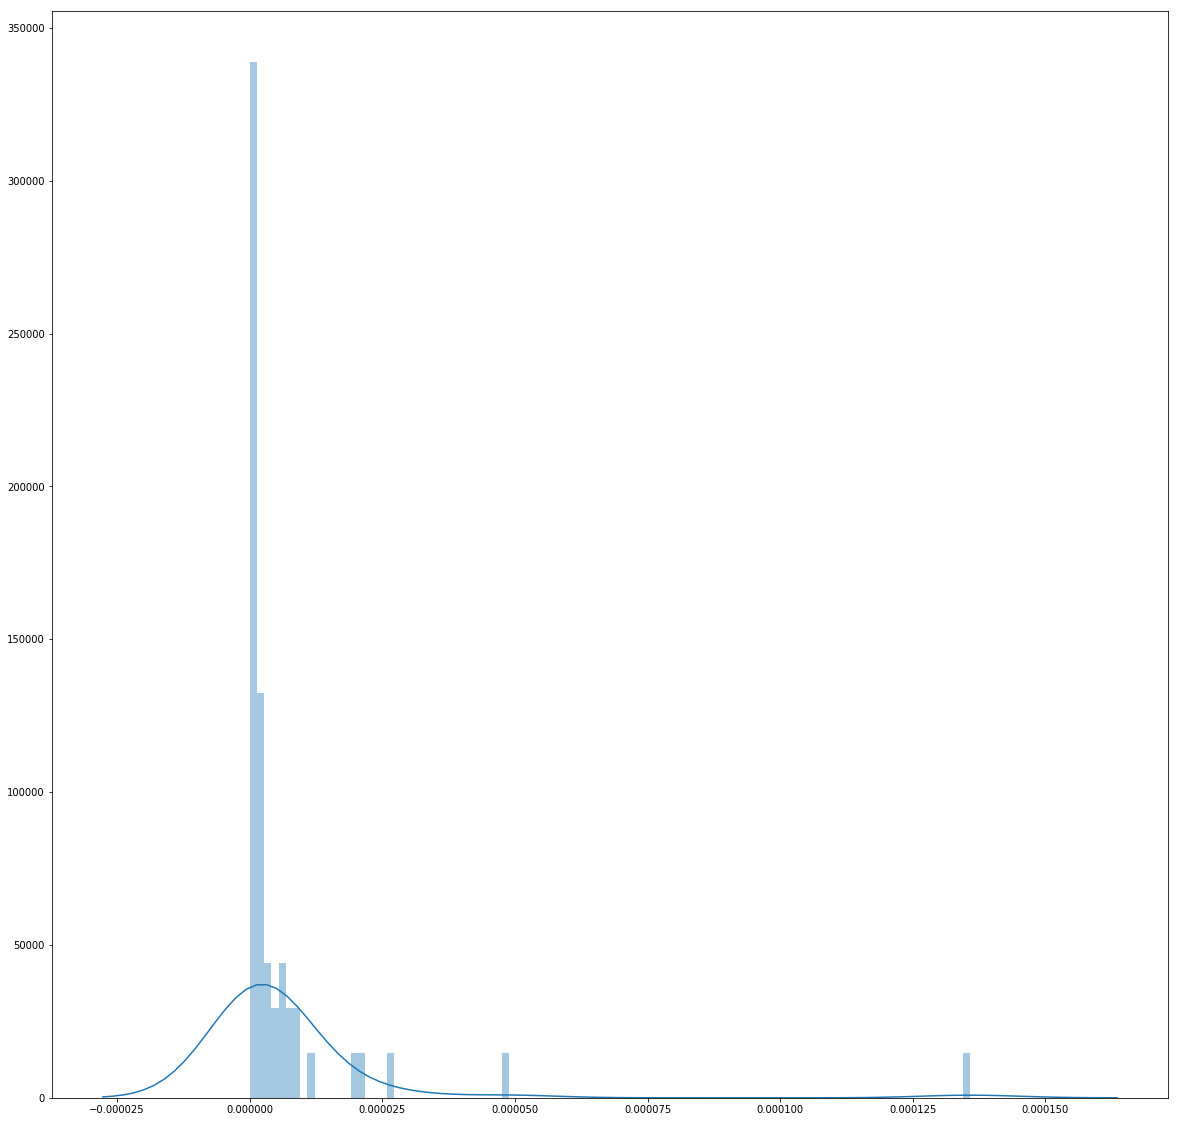

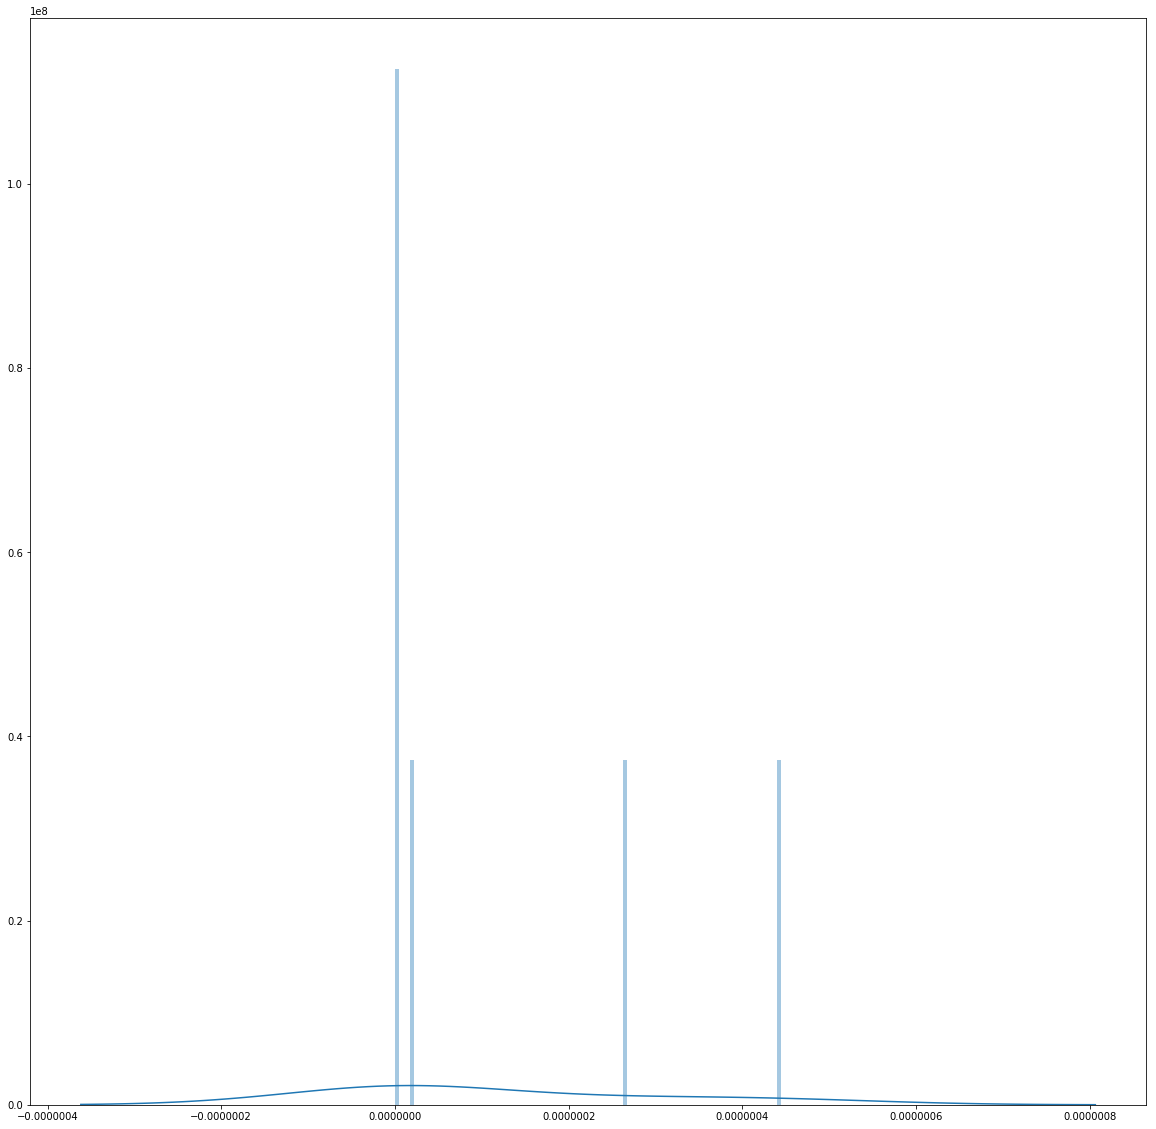

In [132]:

for p in proportions:
    ax = plt.subplots(figsize=(20,20))[1]
    sns.distplot(p[p!=0], bins=100, ax=ax)
    plt.show()

In [97]:
np.sum(np.divide(num_possible, num_possible[0]))

337.8481012658227

In [67]:
adic_undirected_As[4].shape

(450, 450)

In [101]:
prob

[0.08146283863405059,
 0.24555606758840806,
 0.06590180852614737,
 0.006870284668269169,
 0.0005665386164560215]

In [ ]:
for A in adic_As: 
    ase = AdjacencySpectralEmbed(k=5)
    Xhat, Yhat = ase.fit_transform(A)
    pairplot(Xhat)

In [126]:
from scipy.special import comb

proportions = []
for i, adic_num_present in enumerate(num_present):
#     proportions.append(np.divide(adic_num_present, comb(num_possible, i + 1)))
    possible = comb(num_possible, i + 1)
    p = np.divide(adic_num_present, possible, out=np.zeros_like(adic_num_present), where=possible!=0)
    proportions.append(p)

[array([0.13924051, 0.05645161, 0.03139013, 0.06369427, 0.01431493,
        0.        , 0.08597285, 0.09708738, 0.0125523 , 0.18      ,
        0.07035176, 0.10222222, 0.01190476, 0.01229508, 0.        ,
        0.        , 0.00952381, 0.11688312, 0.01467505, 0.27027027,
        0.05940594, 0.05627706, 0.03797468, 0.06603774, 0.12727273,
        0.05494505, 0.25      , 0.05607477, 0.09333333, 0.        ,
        0.12337662, 0.20967742, 0.2173913 , 0.17346939, 0.0862069 ,
        0.15929204, 0.05806452, 0.04545455, 0.        , 0.08      ,
        0.        , 0.12359551, 0.08196721, 0.        , 0.08139535,
        0.15254237, 0.33333333, 0.10869565, 0.05357143, 0.15909091,
        0.26086957, 0.08080808, 0.25      , 0.08421053, 0.05494505,
        0.        , 0.17283951, 0.08974359, 0.15454545, 0.05633803,
        0.05      , 0.        , 0.1       , 0.29032258, 0.13636364,
        0.12121212, 0.18181818, 0.10633484, 0.01260504, 0.22580645,
        0.07894737, 0.14563107, 0.04950495, 0.11

In [124]:
f = [np.nanmean(p) for p in proportions]

[36.65827738532276,
 8.197478131446493,
 0.32470487080450505,
 0.0003574255841867247,
 7.3760106753596e-07]